# Introduction
---
In this assignment, we will try to find the best model for a given dataset.
We will perform the following stages:
1. Import the data
2. Preliminary data analysis
3. Preprocessing
4. Trying different models
5. Balancing the data
6. Grid search for the best hyperparameters

We will choose between the following classification models __learned in class so far__:
- Logistic Regression
- Decision Tree
- Random Forest
- AdaBoost
- Gradient Boosting
- XGBoost

In [41]:
import pickle
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
import xgboost as xgb
from sklearn.model_selection import KFold, GridSearchCV
import statistics
from sklearn.base import clone
from collections import Counter
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from imblearn.over_sampling import RandomOverSampler

# 1. Import the Data set
---

In [2]:
## Load the data
with open('../../data/ass2.pickle', 'rb') as f:
    data = pickle.load(f)

In [3]:
## Example of train samples
df = pd.DataFrame(data['train'])
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f33,f34,f35,f36,f37,f38,f39,f40,f41,target
51905,1,0,0,0,0,0,2,1,2,2,...,0,0,0,2,0,0,0,0,0,2
52612,0,0,0,0,0,0,2,1,0,0,...,0,0,0,2,0,0,0,0,0,2
61699,2,1,2,1,1,0,2,2,0,0,...,0,0,0,1,0,0,0,0,0,2
6291,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,2
17484,0,0,0,0,0,0,1,1,2,0,...,0,0,0,2,1,2,0,0,0,2


#### Extract train, dev, test datasets (x and y)

In [4]:
## Get train dev test Xs and ys (X type is dataFrame and y type is Series)
df_train = data['train']
X_train = df_train.iloc[:, :-1]
y_train = df_train.iloc[:, -1]

df_dev = data['dev']
X_dev = df_dev.iloc[:, :-1]
y_dev = df_dev.iloc[:, -1]

df_test = data['test']
X_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1]

# 2. Preliminary data analysis
---
In this section, we will analyze the data and try to understand it better.
We will focus on the following:
- What is the problem type? (classification/regression)
- What is the data distribution?
- What is the data range?
- Are there missing values?
- What is the correlation between the features?
- What is the correlation between each feature and the label?
- What is the distribution of each feature?

In [5]:
print(f"X_train shape: {X_train.shape}")
print(f"X_dev shape: {X_dev.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (40533, 42)
X_dev shape: (13512, 42)
X_test shape: (13512, 42)


In [44]:
# count the number of samples for each label in the train dataset
print(f"Distribution of labels in the train dataset, order from most common to least: {list(Counter(y_train).items())}")

Distribution of labels in the train dataset, order from most common to least: [(2, 26734), (1, 9882), (0, 3917)]
Distribution of labels in the train dataset, order from most common to least: [(2, 8870), (0, 1262), (1, 3380)]


#### We can see that this is a classification problem and that the train data is not well-balanced, there are significantly more 2s than 1s or 0s

In [7]:
# check samples values range
print(f"X_train values range: {X_train.min().min()} - {X_train.max().max()}")

X_train values range: 0 - 2


In [8]:
# check if there are missing values
print(f"Number of missing values in the train dataset: {X_train.isnull().sum().sum()}")

Number of missing values in the train dataset: 0


#### there are no missing values and the possible values of each feature are between options 0, 1 and 2

<Axes: >

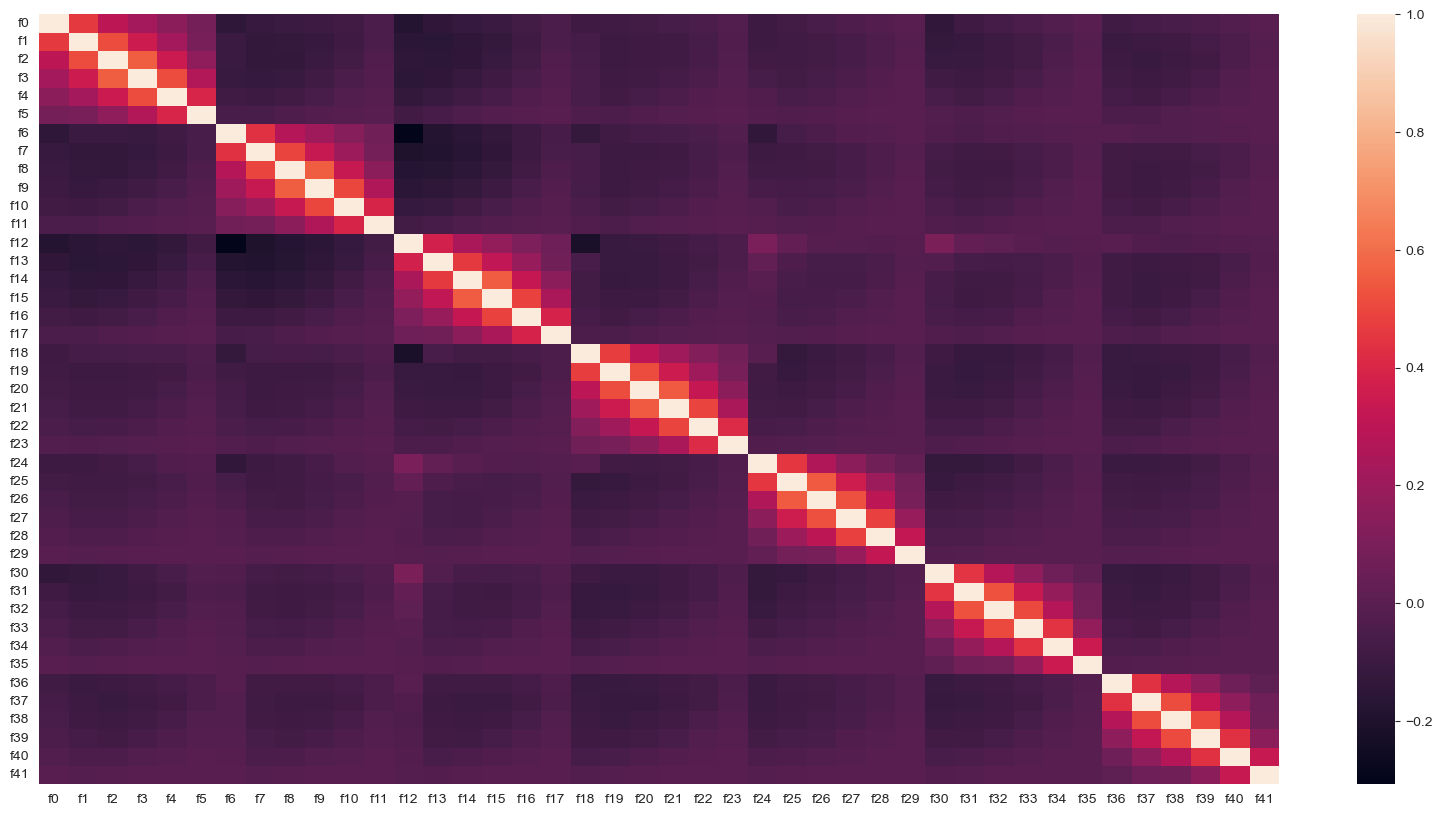

In [9]:
plt.figure(figsize=(20, 10))
# check correlation between features
sns.heatmap(X_train.corr())
# TODO: what do we understand from this? maybe create a new correlation method or remove this section

In [10]:
def plot_feature_label_correlation(X: pd.DataFrame, y: pd.Series):
    # show correlation between each feature and the label
    all_correlations = []
    for col in X.columns:
        corr = X[col].corr(y)
        all_correlations.append(corr)
    # plot the correlation between each feature and the label
    plt.figure(figsize=(20, 10))
    # add a horizontal line at 0.01 and -0.01
    plt.axhline(y=0.01, color='r', linestyle='-')
    plt.axhline(y=-0.01, color='r', linestyle='-')
    plt.yticks([-0.075, -00.5, -0.025, -0.01, 0, 0.01, 0.025, 0.05, 0.075])

    # add title and labels
    plt.title('Correlation between each feature and the label')
    plt.xlabel('Features')
    plt.ylabel('Correlation')
    # plot the barplot
    sns.barplot(x=X.columns, y=all_correlations)
    return all_correlations


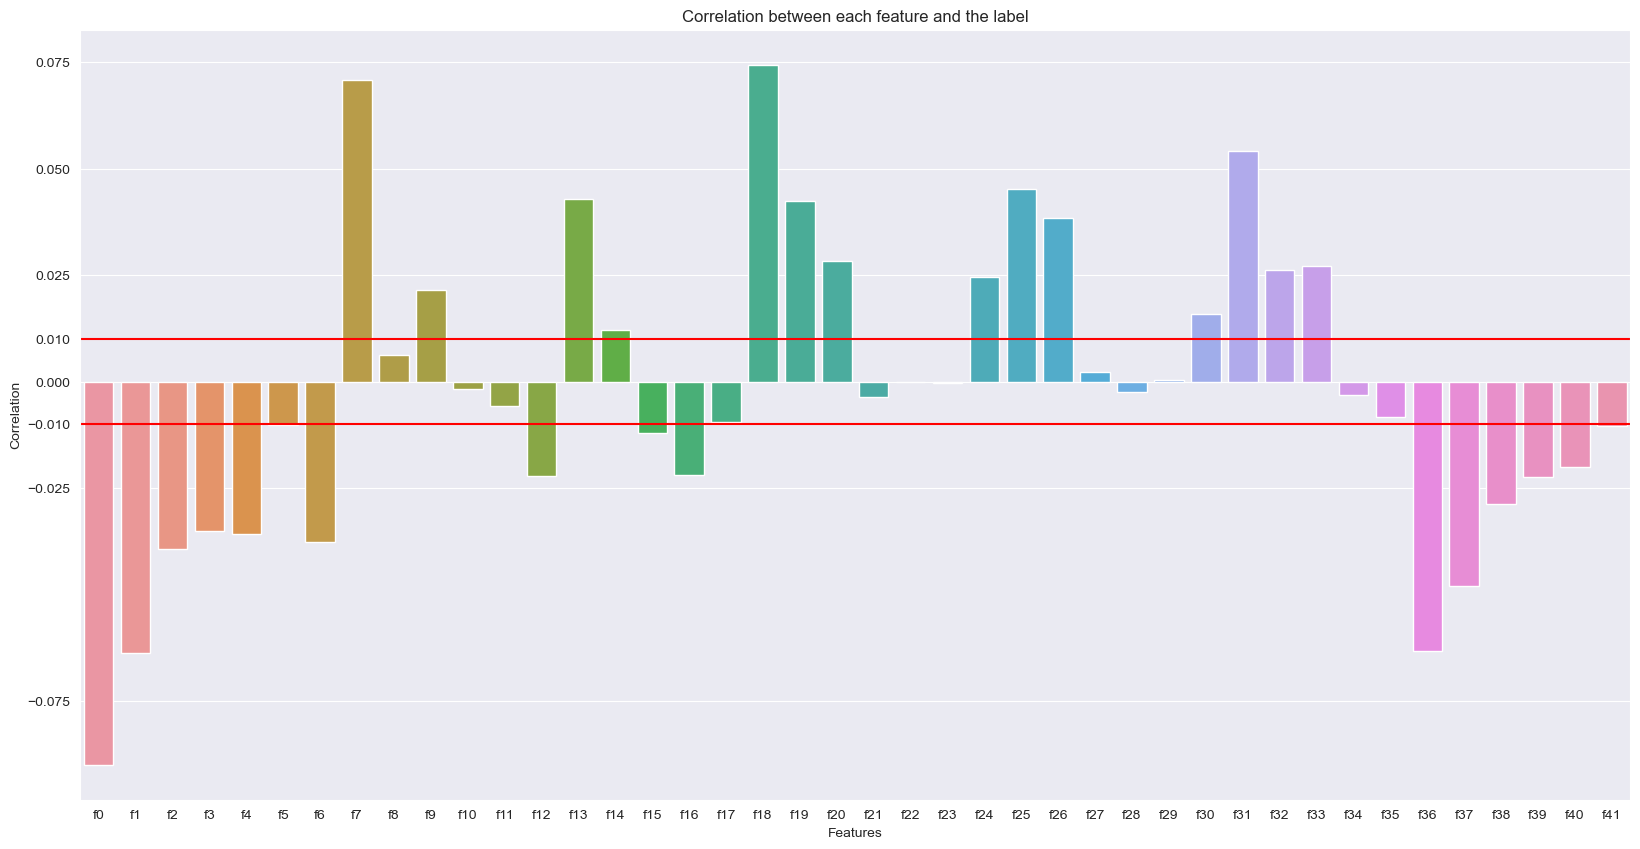

In [11]:
# show correlation between each feature and the label
correlations = plot_feature_label_correlation(X_train, y_train)

##### We can see that there is no direct correlation between a single feature and the label because all values are between -0.1 and 0.1, not even close to 1 or -1
Yet we can still learn from this graph that there are some features that are a bit more correlated with the label than others, __we can reduce the number of features by removing the ones that are not correlated at all.__

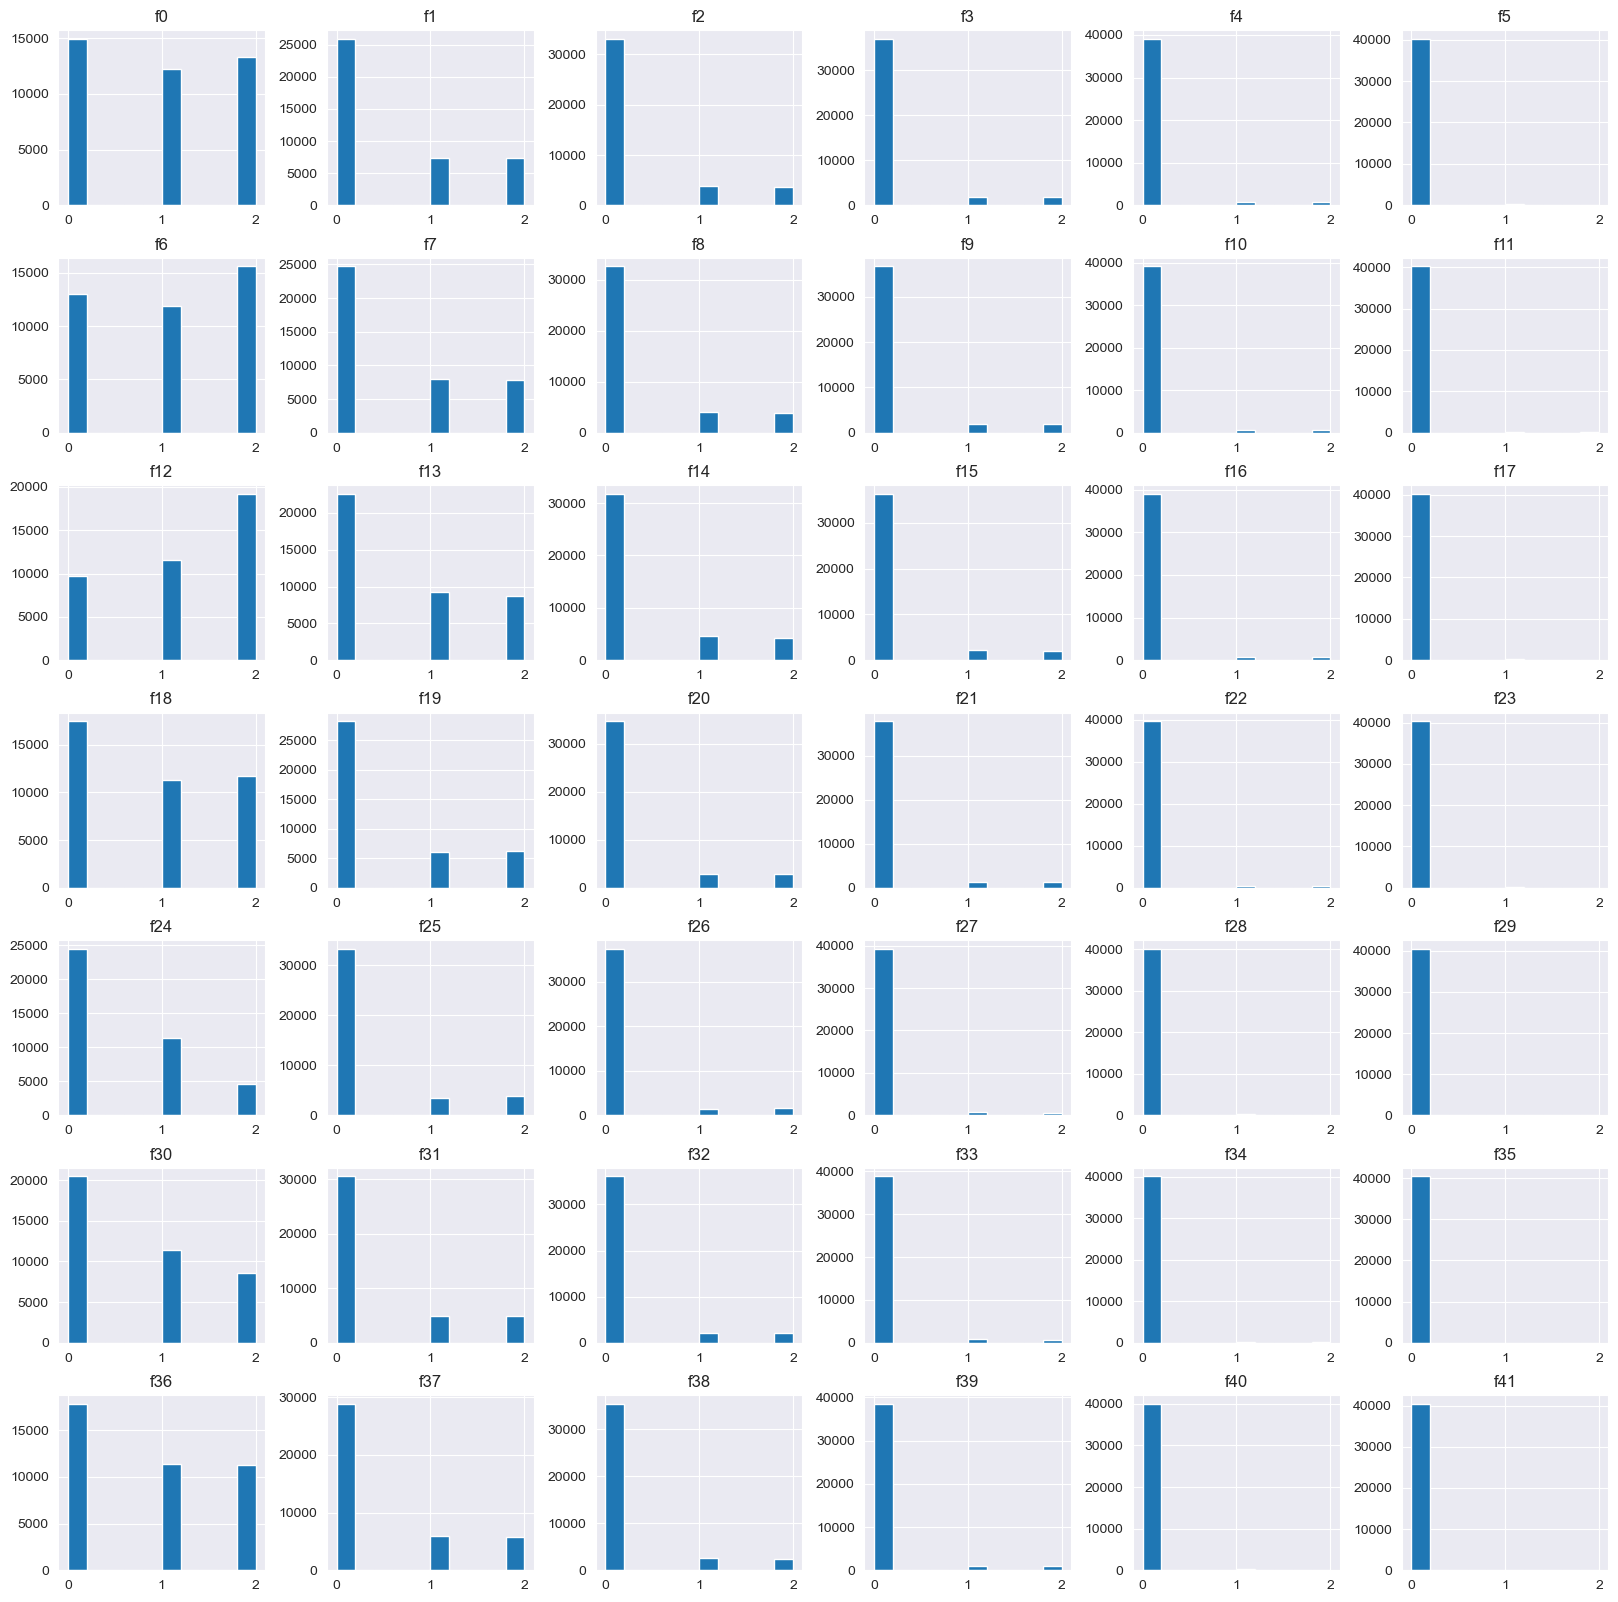

In [12]:
# show the distribution of the features
hist = X_train.hist(figsize=(20, 20))

#### We can see that the distribution of each feature is not uniform, some features are almost always 0, and dont contribute to the model, only increase the size of the dataset

# 3. Preprocessing
---
In this section, we will preprocess the data in order to improve the model's performance.
We will do the following:
- Create copies of our datasets and modify them instead of the original ones, to be able to compare results later.
- Remove features that are extremely not correlated with the label.
- Remove features that are almost always 0.

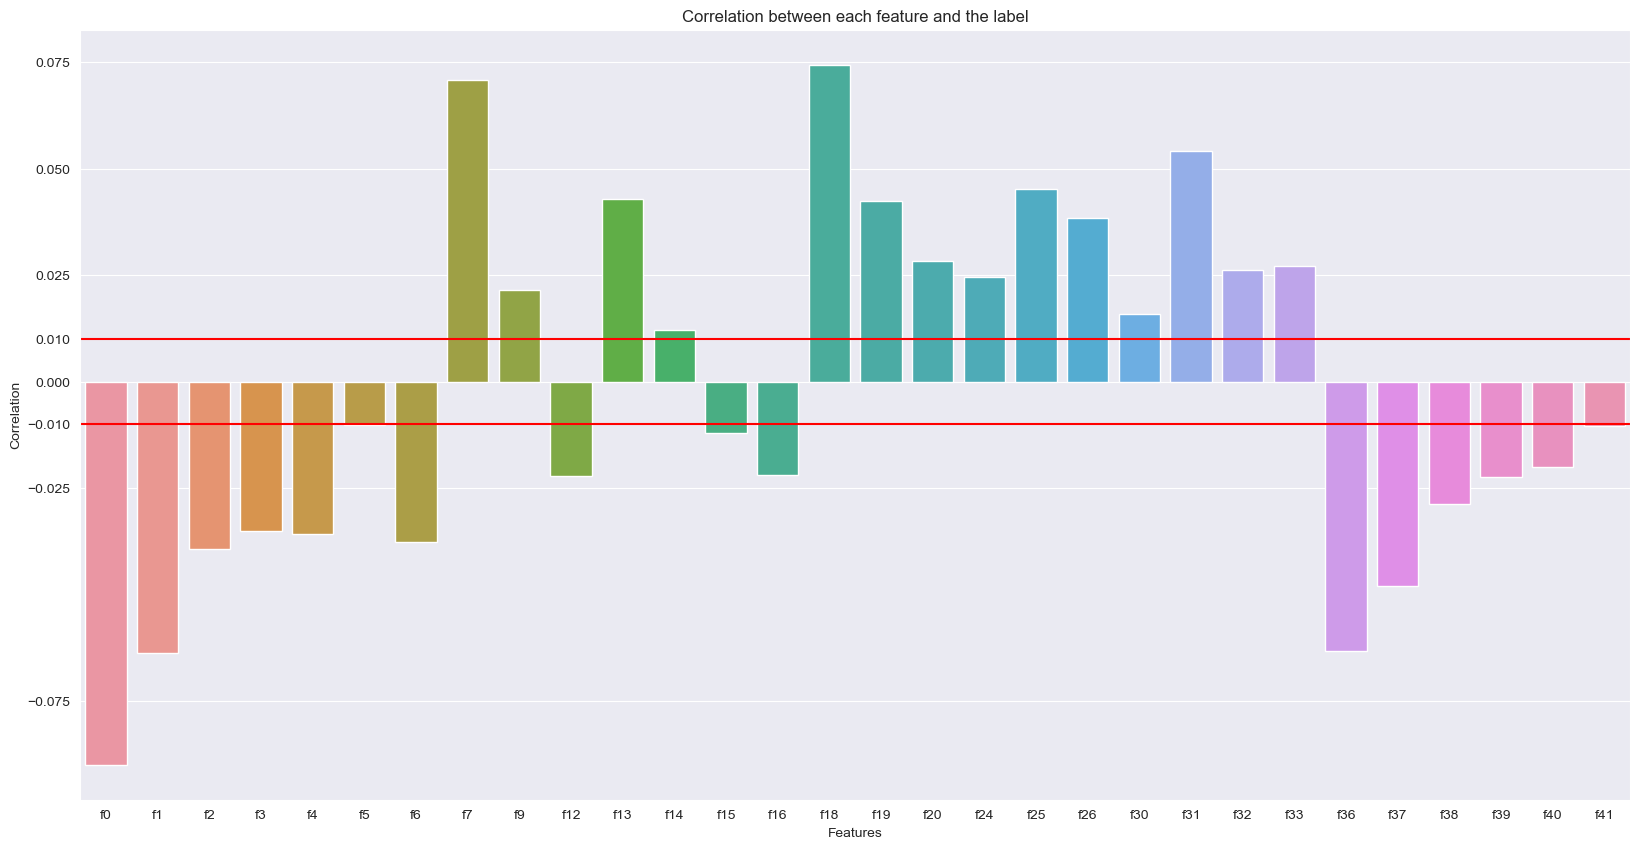

In [13]:
# remove that feature that has a correlation lower than 0.01 and higher than -0.01 with the label
all_correlations = np.array(correlations)
indices = np.where(np.logical_and(all_correlations < 0.01, all_correlations > -0.01))
uncorrelated_feature = X_train.columns[indices]
X_train_modified = X_train.drop(columns=uncorrelated_feature)
X_dev_modified = X_dev.drop(columns=uncorrelated_feature)
X_test_modified = X_test.drop(columns=uncorrelated_feature)
correlations_v2 = plot_feature_label_correlation(X_train_modified, y_train)

In [16]:
# find the indices of the features that are 0 in more than 90% of the samples
indices = np.where(X_train_modified.sum(axis=0) < 0.1 * X_train_modified.shape[0])
# remove those features from the datasets
X_train_modified = X_train_modified.drop(columns=X_train_modified.columns[indices])
X_dev_modified = X_dev_modified.drop(columns=X_dev_modified.columns[indices])
X_test_modified = X_test_modified.drop(columns=X_test_modified.columns[indices])

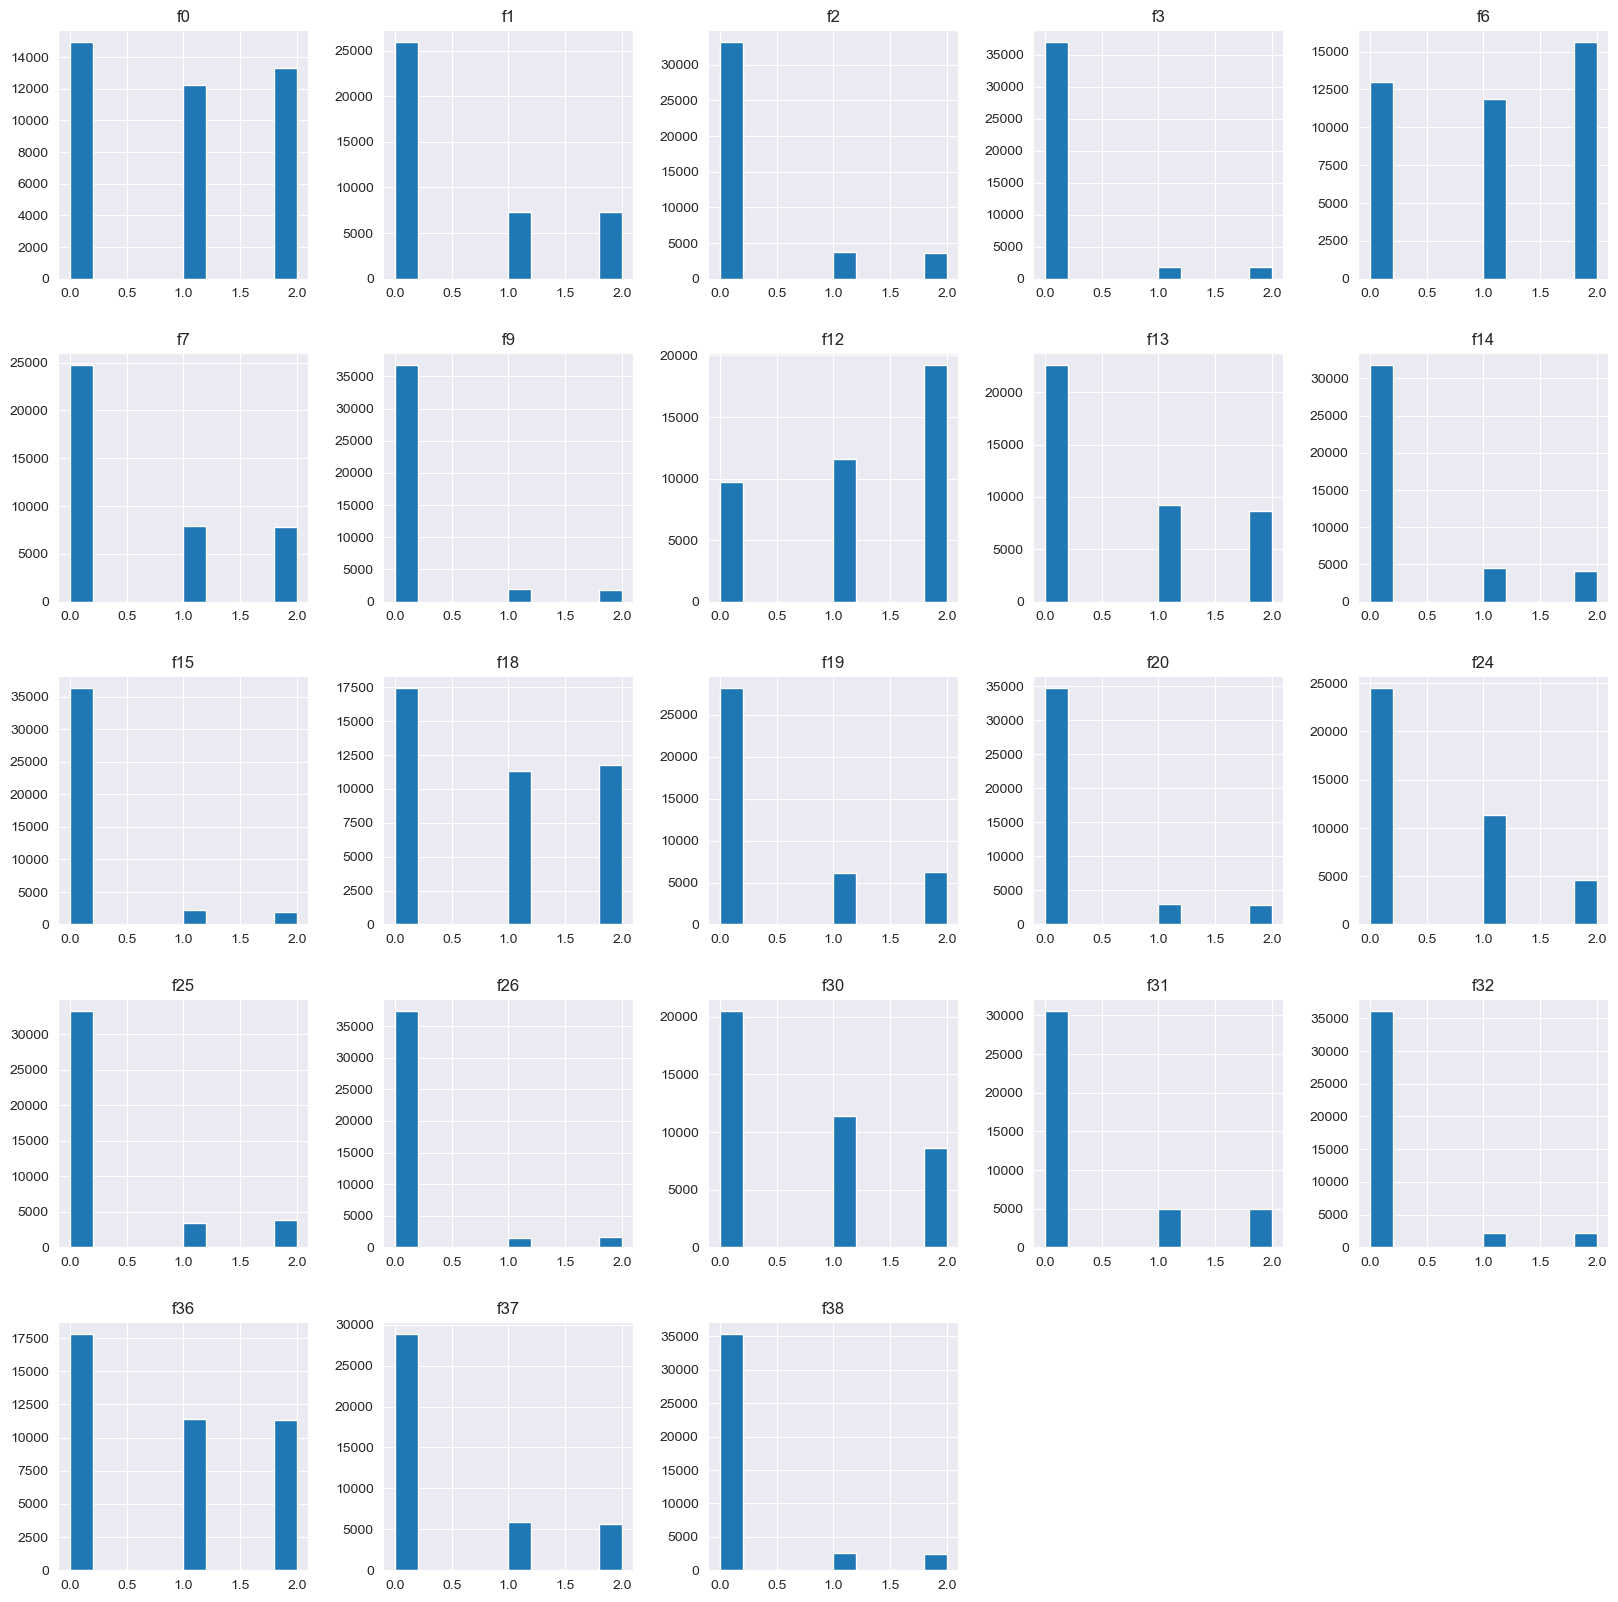

In [17]:
hist_v2 = X_train_modified.hist(figsize=(20, 20))

We are left with significantly fewer features in our modified datasets, which will hopefully improve the model's performance

# 4. Trying different models on the original datasets
---
In this section, we will try different models on the original datasets, without any modifications to the models and compare their performance.
However, we will use the KFold method on a combination of the train and dev datasets, to get a better estimate of each model's performance, before choosing the best one and testing it on the test dataset.

In [18]:
# union dev and train datasets (for using in kfold)
print(X_train.shape)
print(X_dev.shape)
X_trainDev = pd.concat([X_train, X_dev], axis=0)
y_trainDev = pd.concat([y_train, y_dev], axis=0)

(40533, 42)
(13512, 42)


In [24]:
## defining a helper of kfold on train and dev datasets

def run_k_fold(model,X, y):
  kf = KFold(n_splits=5,shuffle=True)
  accs = []
  for train_index, test_index in kf.split(X.values):
      X_subtrain, X_subtest = X.values[train_index], X.values[test_index]
      y_subtrain, y_subtest = y.values[train_index], y.values[test_index]
      cloned_model = clone(model)
      cloned_model.fit(X_subtrain,y_subtrain)
      acc = accuracy_score(y_subtest, cloned_model.predict(X_subtest))
      accs.append(acc)
  mean_acc = statistics.mean(accs)
  print(f"Mean accuracy of {model.__class__.__name__} is {mean_acc}")
  return mean_acc


In [28]:
## function to try several models using kfold
def choose_model_with_k_fold(models_list, X, y):
    all_accs = []
    for model in models_list:
        print(f"Trying model: {model.__class__.__name__}")
        acc = run_k_fold(model, X, y)
        all_accs.append(acc)
        print("_________________________________________________________")
    best_acc_model = models_list[np.argmax(all_accs)]
    print(f"Best model: {best_acc_model.__class__.__name__}")
    best_acc_model.fit(X, y)
    return best_acc_model

In [29]:
models = [
    DecisionTreeClassifier(),
    LogisticRegression(max_iter=10000),
    GradientBoostingClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    xgb.XGBClassifier()
]

In [30]:
# trying several models using kfold
best_model = choose_model_with_k_fold(models, X_trainDev, y_trainDev)
# check accuracy on test dataset
y_pred = best_model.predict(X_test)
score = accuracy_score(y_test, y_pred)
print(f"Accuracy on test dataset: {score}")

Trying model: DecisionTreeClassifier
Mean accuracy of DecisionTreeClassifier is 0.7263946711074105
_________________________________________________________
Trying model: LogisticRegression
Mean accuracy of LogisticRegression is 0.6611527430844666
_________________________________________________________
Trying model: GradientBoostingClassifier
Mean accuracy of GradientBoostingClassifier is 0.7532796743454528
_________________________________________________________
Trying model: RandomForestClassifier
Mean accuracy of RandomForestClassifier is 0.8090665186418725
_________________________________________________________
Trying model: AdaBoostClassifier
Mean accuracy of AdaBoostClassifier is 0.7275048570635582
_________________________________________________________
Trying model: XGBClassifier
Mean accuracy of XGBClassifier is 0.8305856230918679
_________________________________________________________
Best model: XGBClassifier
Accuracy on test dataset: 0.8326672587329781


We can see that without any tuning to the models, the best model is the XGBClassifier, with an accuracy of 0.83 on the test dataset.
We will now try to improve the model's performance by choosing the best hyperparameters of the model, using the GridSearchCV method.


# 5. Balancing the dataset
---
In this section, we will try to balance the dataset, in order to improve the model's accuracy.

In [47]:
# create a balanced dataset by oversampling the minority classes
sampler = RandomOverSampler(sampling_strategy='not majority')
X_train_balanced, y_train_balanced = sampler.fit_resample(X_trainDev, y_trainDev)

In [49]:
print(f"Distribution of labels in the balanced train dataset, order from most common to least: {list(Counter(y_train_balanced).items())}")

Distribution of labels in the balanced train dataset, order from most common to least: [(2, 35603), (1, 35603), (0, 35603)]


Now lets check if the accuracy of the models is affected by the balanced dataset.

In [48]:
# trying several models using kfold
best_model_balanced = choose_model_with_k_fold(models, X_train_balanced, y_train_balanced)
# check accuracy on test dataset
y_pred = best_model_balanced.predict(X_test)
score = accuracy_score(y_test, y_pred)
print(f"Accuracy on test dataset: {score}")

Trying model: DecisionTreeClassifier
Mean accuracy of DecisionTreeClassifier is 0.9240513296728192
_________________________________________________________
Trying model: LogisticRegression
Mean accuracy of LogisticRegression is 0.4346637995395457
_________________________________________________________
Trying model: GradientBoostingClassifier
Mean accuracy of GradientBoostingClassifier is 0.6393562356519479
_________________________________________________________
Trying model: RandomForestClassifier
Mean accuracy of RandomForestClassifier is 0.9575597573250061
_________________________________________________________
Trying model: AdaBoostClassifier
Mean accuracy of AdaBoostClassifier is 0.5771891205313454
_________________________________________________________
Trying model: XGBClassifier
Mean accuracy of XGBClassifier is 0.8014305996636761
_________________________________________________________
Best model: RandomForestClassifier
Accuracy on test dataset: 0.8148312611012434


We can see that the accuracies of most models are much higher, getting up to 0.95, which might seem good but in fact is not, since the model chosen is different from the one chosen before. and its accuracy on the test dataset is much lower than the accuracy of the XGBClassifier on the original dataset. This is a clear indication that using the balanced dataset caused the model to overfit the data.

# 6.Choosing the best hyperparameters for the XGBClassifier
---
In this section, we will use the GridSearchCV method to find the best hyperparameters for the XGBClassifier model.
Although this method is very time-consuming, we will perform it on our modified datasets, which have fewer features, in order to reduce the time it takes to run.
First, we need to make sure the accuracy of the models is not affected by the reduced number of features, so we will run the same models as before, but on the modified datasets.

In [31]:
# union modified dev and train datasets (for using in kfold)
print(X_train_modified.shape)
print(X_dev_modified.shape)
X_trainDev_modified = pd.concat([X_train_modified, X_dev_modified], axis=0)
y_trainDev_modified = pd.concat([y_train, y_dev], axis=0)

(40533, 23)
(13512, 23)


In [32]:
best_model_modified = choose_model_with_k_fold(models, X_trainDev_modified, y_trainDev_modified)
y_pred = best_model_modified.predict(X_test_modified)
score = accuracy_score(y_test, y_pred)
print(f"Accuracy on test dataset: {score}")

Trying model: DecisionTreeClassifier
Mean accuracy of DecisionTreeClassifier is 0.7056341937274494
_________________________________________________________
Trying model: LogisticRegression
Mean accuracy of LogisticRegression is 0.6600795633268572
_________________________________________________________
Trying model: GradientBoostingClassifier
Mean accuracy of GradientBoostingClassifier is 0.7468961050976038
_________________________________________________________
Trying model: RandomForestClassifier
Mean accuracy of RandomForestClassifier is 0.7823110370987141
_________________________________________________________
Trying model: AdaBoostClassifier
Mean accuracy of AdaBoostClassifier is 0.725895087427144
_________________________________________________________
Trying model: XGBClassifier
Mean accuracy of XGBClassifier is 0.8186511240632806
_________________________________________________________
Best model: XGBClassifier
Accuracy on test dataset: 0.8202338661930136


We can see that the accuracy of the models is not significantly affected by the reduced number of features, so we can proceed to the next step.

In [50]:
# perform grid search on the best model XGBClassifier
def grid_search_wrapper(model, X, y, param_grid, test_X, test_y):
    clf = GridSearchCV(model, param_grid, n_jobs=5, cv=5, verbose=2, refit=True)
    clf.fit(X, y)
    print(f"Best parameters for {model.__class__.__name__}: \n{clf.best_params_} \nwith score: {clf.best_score_}")
    y_pred = clf.predict(test_X)
    score = accuracy_score(test_y, y_pred)
    print(f"Accuracy on test dataset: {score}")
    return clf.best_estimator_

In [ ]:
# create a parameter grid for the XGBClassifier with the most important hyperparameters
parameters = {
    'max_depth': [10,11,12,13,14],
    'alpha': [3,4,5,6,7,8],
    'reg_lambda': [3,4,5,6,7],
    "eta" : [0.6, 0.7, 0.8, 0.9, 1]
}

best_model = grid_search_wrapper(xgb.XGBClassifier(), X_trainDev_modified, y_trainDev_modified, parameters, X_test_modified, y_test)

Fitting 5 folds for each of 750 candidates, totalling 3750 fits


In [ ]:
# run on original dataset with best parameters
classifier = xgb.XGBClassifier(best_model.best_params_)
# TODO: theres an error in the line above, returned value is the best estimator, enter values manually since it takes too long to run
classifier.fit(X_trainDev, y_trainDev)
y_pred = classifier.predict(X_test)
score = accuracy_score(y_test, y_pred)
print(f"Accuracy on test dataset: {score}")